# Visualising MCMC sampling from a 2D target distribution

Credit: This material has been adopted from the Harvard course on Monte Carlo Methods by Pavlos Protopapas and the solutions written by Dan Hendrycks


In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

$$
\newcommand{\var}{{\rm var}}
\newcommand{\cov}{{\rm cov}}
\newcommand{\corr}{{\rm corr}}
\newcommand{\xss}{x^{(i+1)}}
\newcommand{\xs}{x^{\star}}
\newcommand{\xt}{x^{(i)}}
\newcommand{\yss}{y^{(i+1)}}
\newcommand{\ys}{y^{\star}}
\newcommand{\yt}{y^{(i)}}
\newcommand{\xa}{x_a}
\newcommand{\xb}{x_b}
$$

# Target distribution

Suppose we have a bivariate target distribution $p(x, y)$ that has the following form:


$$ f(x, y) =  \frac{1}{C} \exp \left( -\frac{(x^2 \,y^2+x^2+y^2-8x-8y)}{2} \right) $$

As is typical in Bayesian inference, we don't know the value of the normalizing constant $C$, so we can't sample from this distribution directly. However, MCMC techniques allow us to sample from probability distributions without knowing this constant. 

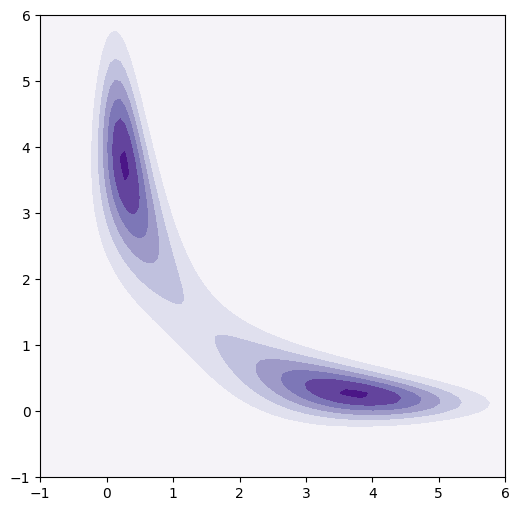

In [2]:
# define a function to evaluate the target distribution (up to a constant)
def p(x, y):
    return np.exp(-((x*y)**2 + x**2 + y**2 - 8*x - 8*y)/2.)

plot_x, plot_y = np.meshgrid(np.linspace(-1, 6, 100), np.linspace(-1, 6, 100))

plt.figure(figsize=[6,6])
plt.contourf(plot_x, plot_y, p(plot_x, plot_y), cmap="Purples")

# Metropolis-Hastings

Let's start by implementing Metropolis-Hastings algorithm. 

The below code initialises `x_trace` and `y_trace` variables and provides code how to visualise them afterwards. 

You could initialise from say $(x_0, y_0) = (4, 2)$ and start out by a proposal distribution $N(x, 0.5^2)$. 

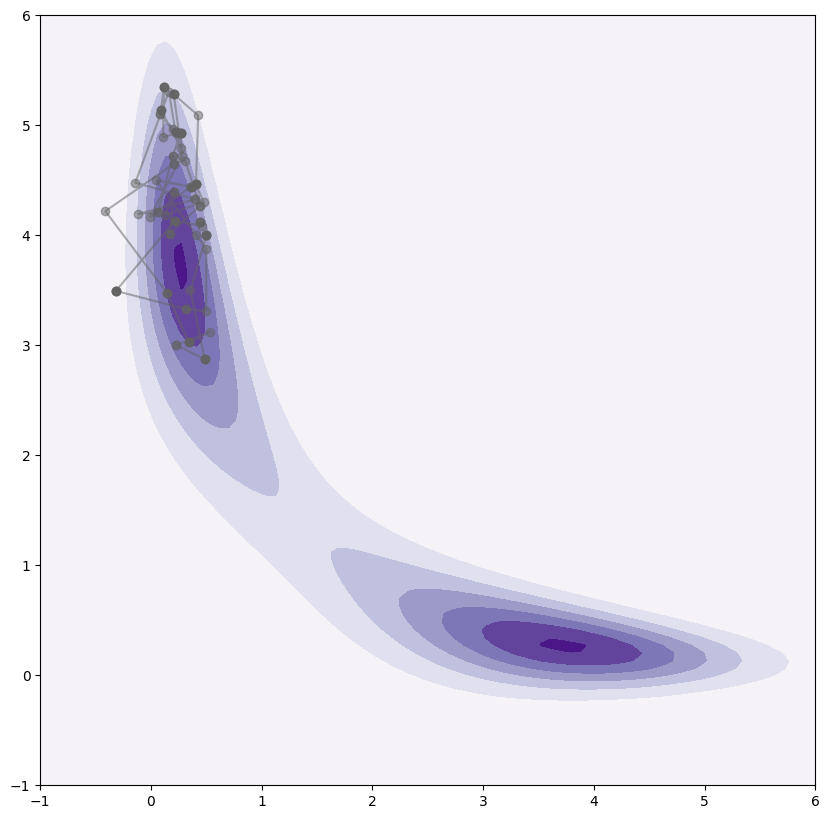

In [30]:
# specify the number of iterations
n_iter = 100

# initialise variables to store the trace of the Markov chain
x_trace = np.zeros(n_iter)
y_trace = np.zeros(n_iter)

x_trace[0] = 0.5
y_trace[0] = 4
################
for i in range(1,n_iter):
    # sample proposal
    mn = [x_trace[i-1], y_trace[i-1]]
    sigma =  np.eye(2)*(0.5-0.001*i)**2

    x_prop, y_prop = np.random.multivariate_normal(mn, sigma)
    
    # compute acceptance alpha
    A = sp.stats.multivariate_normal.pdf([x_prop, y_prop], mean=mn, cov=sigma, allow_singular=False)
    B = sp.stats.multivariate_normal.pdf(mn, mean=[x_prop, y_prop], cov=sigma, allow_singular=False)

    alpha = (p(x_prop, y_prop) * B )/(p(x_trace[i-1], y_trace[i-1]) * A)

    # sample u from uniform
    u = np.random.uniform()

    # set sample to theta' else same if  u < min {1, alpha}
    if u < min(1, alpha):
        x_trace[i] = x_prop
        y_trace[i] = y_prop
    else:
        x_trace[i] = x_trace[i-1]
        y_trace[i] = y_trace[i-1]
################

# visualise the trace
plt.figure(figsize=[10, 10])
plt.contourf(plot_x, plot_y, p(plot_x, plot_y), cmap="Purples")
plt.plot(x_trace, y_trace, 'o-', c="#636363", alpha=0.5)

/var/folders/3z/m0832prx66v_vl5fvz9hyysm0000gr/T/ipykernel_59980/2833690112.py:6: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(plot_x, plot_y, p(plot_x, plot_y), label=u'p(x,y)')


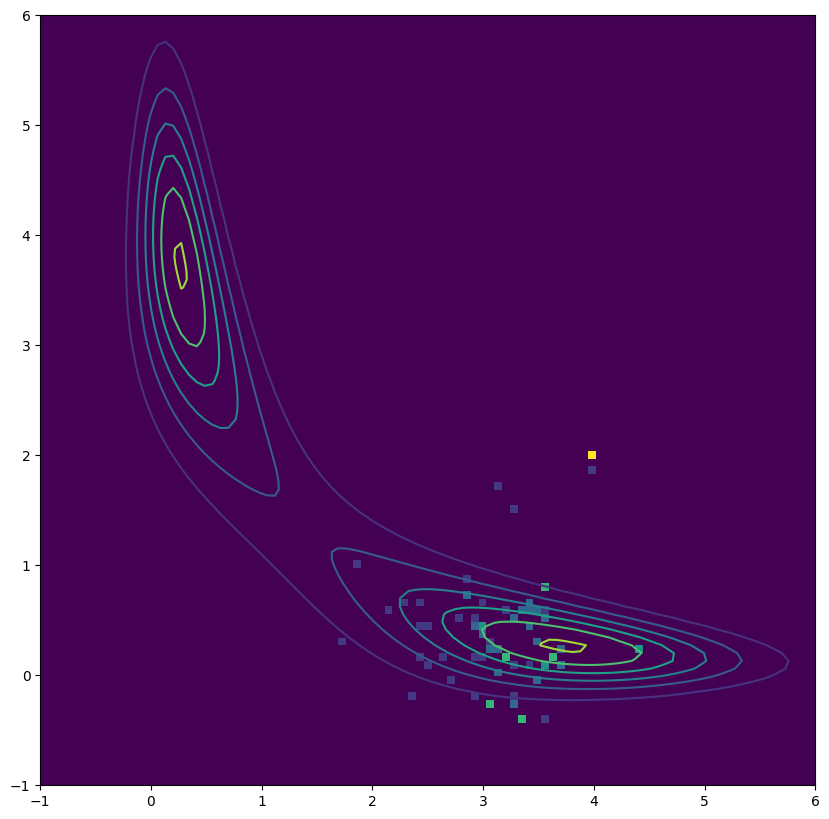

In [13]:
# Another way to visualise the samples from the target is as follows:
plt.figure(figsize=[10, 10])
x_grid = np.linspace(-1., 6., 100)
y_grid = np.linspace(-1., 6., 100)
plt.hist2d(x_trace, y_trace, bins=[x_grid, y_grid])
plt.contour(plot_x, plot_y, p(plot_x, plot_y), label=u'p(x,y)')
plt.show()

Once you have a working MH sampler, can you find a proposal variance that works better?

# Gibbs sampling

For comparison, now let's implement a Gibbs sampler for the same target distribution. This requires easy-to-sample-from *conditional* distributions.  Luckily, the original $p(x, y)$ can be simplified to reveal the following expressions

$$ p(x \mid y) = g(y) e^{-\left(x-\frac{4}{(1+y^2)}\right)^{2}\frac{(1+y^2)}{2}} $$

and

$$ p(y \mid x) = g(x) e^{-\left(y-\frac{4}{(1+x^2)}\right)^{2}\frac{(1+x^2)}{2}} $$

where $g(y)$ does not depend on $x$, and $g(x)$ does not depend on $y$. Therefore, we can express these as Gaussians:

$$ x \mid y \sim N\left(\frac{4}{1+y^2}, \sqrt{\frac{1}{1+y^2}}\right) $$

and similarly

$$ y \mid x \sim N\left(\frac{4}{1+x^2}, \sqrt{\frac{1}{1+x^2}}\right) $$

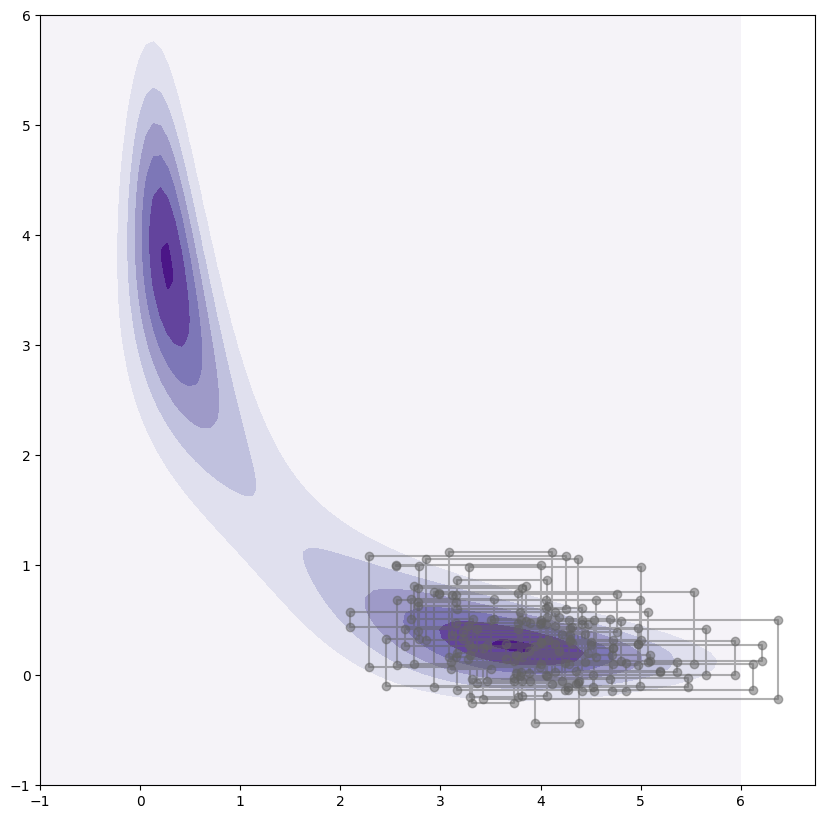

In [33]:
# specify the number of iterations
n_iter = 200

# initialise variables to store the trace of the Markov chain
x_trace = np.zeros(n_iter)
y_trace = np.zeros(n_iter)

x_trace[0] = 4
y_trace[0] = 0.5
################
for i in range(1,n_iter):
#    if i%2 == 1:
        # sample x
#        x_trace[i] = np.random.normal(loc=4/(1+y_trace[i-1]**2), scale=(1/(1+y_trace[i-1]**2))**0.5)
#        y_trace[i] = y_trace[i-1]
#    else:
        # sample y
#        y_trace[i] = np.random.normal(loc=4/(1+x_trace[i]**2), scale=(1/(1+x_trace[i]**2))**0.5)
#        x_trace[i] = x_trace[i-1]

    if i%2 == 1:
        # sample y
        y_trace[i] = np.random.normal(loc=4/(1+x_trace[i-1]**2), scale=(1/(1+x_trace[i-1]**2))**0.5)
        x_trace[i] = x_trace[i-1]
    else:
        # sample y
        x_trace[i] = np.random.normal(loc=4/(1+y_trace[i]**2), scale=(1/(1+y_trace[i]**2))**0.5)
        y_trace[i] = y_trace[i-1]
################

# visualise the trace
plt.figure(figsize=[10, 10])
plt.contourf(plot_x, plot_y, p(plot_x, plot_y), cmap="Purples")
plt.plot(x_trace, y_trace, 'o-', c="#636363", alpha=0.5)

# Further diagnostics

In a 2D case, it may be sufficient to look at the 2D plot on its own, but for higher dimensional spaces we must resort to analysing summary statistics and marginal distributions. 

Visualise some of the following:

* Univariate trace plots of $x$ and $y$. Decide how many iterations would be a suitable burn-in to be removed. 
* Univariate histograms
* Summaries of the posterior distribution: Posterior mean and variance
* Autocorrelation and effective sample size

If you had to choose one, would you choose to use MH or Gibbs sampler for this problem?